In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
HIDDEN_SIZE = 30                            # LSTM中隐藏节点的个数。
NUM_LAYERS = 2                              # LSTM的层数。
TIMESTEPS = 10                              # 循环神经网络的训练序列长度。
TRAINING_STEPS = 10000                      # 训练轮数。
BATCH_SIZE = 32                             # batch大小。
TRAINING_EXAMPLES = 10000                   # 训练数据个数。
TESTING_EXAMPLES = 1000                     # 测试数据个数。
SAMPLE_GAP = 0.01                           # 采样间隔。

In [3]:
def generate_data(seq):
    X = []
    y = []
    # 序列的第i项和后面的TIMESTEPS-1项合在一起作为输入；第i + TIMESTEPS项作为输
    # 出。即用sin函数前面的TIMESTEPS个点的信息，预测第i + TIMESTEPS个点的函数值。
    for i in range(len(seq) - TIMESTEPS):
        X.append([seq[i: i + TIMESTEPS]])
        y.append([seq[i + TIMESTEPS]])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)  

# 用正弦函数生成训练和测试数据集合。
test_start = (TRAINING_EXAMPLES + TIMESTEPS) * SAMPLE_GAP
test_end = test_start + (TESTING_EXAMPLES + TIMESTEPS) * SAMPLE_GAP
train_X, train_y = generate_data(np.sin(np.linspace(
    0, test_start, TRAINING_EXAMPLES + TIMESTEPS, dtype=np.float32)))
test_X, test_y = generate_data(np.sin(np.linspace(
    test_start, test_end, TESTING_EXAMPLES + TIMESTEPS, dtype=np.float32)))

In [12]:
train_y.dtype

dtype('float32')

In [4]:
def lstm_model(X, y, is_training):
    # 使用多层的LSTM结构。
    cell = tf.nn.rnn_cell.MultiRNNCell([
        tf.nn.rnn_cell.BasicLSTMCell(HIDDEN_SIZE) 
        for _ in range(NUM_LAYERS)])

    # 使用TensorFlow接口将多层的LSTM结构连接成RNN网络并计算其前向传播结果。
    outputs, _ = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
    output = outputs[:, -1, :]

    # 对LSTM网络的输出再做加一层全链接层并计算损失。注意这里默认的损失为平均
    # 平方差损失函数。
    predictions = tf.contrib.layers.fully_connected(
        output, 1, activation_fn=None)
    
    # 只在训练时计算损失函数和优化步骤。测试时直接返回预测结果。
    if not is_training:
        return predictions, None, None
        
    # 计算损失函数。
    loss = tf.losses.mean_squared_error(labels=y, predictions=predictions)

    # 创建模型优化器并得到优化步骤。
    train_op = tf.contrib.layers.optimize_loss(
        loss, tf.train.get_global_step(),
        optimizer="Adagrad", learning_rate=0.1)
    return predictions, loss, train_op

In [5]:
def run_eval(sess, test_X, test_y):
    # 将测试数据以数据集的方式提供给计算图。
    ds = tf.data.Dataset.from_tensor_slices((test_X, test_y))
    ds = ds.batch(1)
    X, y = ds.make_one_shot_iterator().get_next()
    
    # 调用模型得到计算结果。这里不需要输入真实的y值。
    with tf.variable_scope("model", reuse=True):
        prediction, _, _ = lstm_model(X, [0.0], False)
    
    # 将预测结果存入一个数组。
    predictions = []
    labels = []
    for i in range(TESTING_EXAMPLES):
        p, l = sess.run([prediction, y])
        predictions.append(p)
        labels.append(l)

    # 计算rmse作为评价指标。
    predictions = np.array(predictions).squeeze()
    labels = np.array(labels).squeeze()
    rmse = np.sqrt(((predictions - labels) ** 2).mean(axis=0))
    print("Root Mean Square Error is: %f" % rmse)
    
    #对预测的sin函数曲线进行绘图。
    plt.figure()
    plt.plot(predictions, label='predictions')
    plt.plot(labels, label='real_sin')
    plt.legend()
    plt.show()

env: CUDA_VISIBLE_DEVICE=5
Evaluate model before training.
Root Mean Square Error is: 0.682461


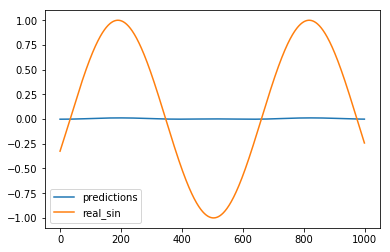

train step: 0, loss: 0.4458927
train step: 1000, loss: 0.0009642086
train step: 2000, loss: 0.00036265975
train step: 3000, loss: 4.7701542e-05
train step: 4000, loss: 5.818813e-06
train step: 5000, loss: 4.211147e-06
train step: 6000, loss: 2.546368e-06
train step: 7000, loss: 2.9251178e-06
train step: 8000, loss: 2.517303e-06
train step: 9000, loss: 4.1278745e-06
Evaluate model after training.
Root Mean Square Error is: 0.001590


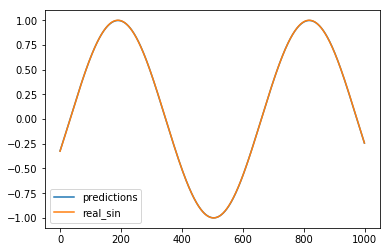

In [9]:
%env CUDA_VISIBLE_DEVICE=5
# 将训练数据以数据集的方式提供给计算图。
ds = tf.data.Dataset.from_tensor_slices((train_X, train_y))
ds = ds.repeat().shuffle(1000).batch(BATCH_SIZE)
X, y = ds.make_one_shot_iterator().get_next()

# 定义模型，得到预测结果、损失函数，和训练操作。
with tf.variable_scope("model"):
    _, loss, train_op = lstm_model(X, y, True)
    
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # 测试在训练之前的模型效果。
    print("Evaluate model before training.")
    run_eval(sess, test_X, test_y)
    
    # 训练模型。
    for i in range(TRAINING_STEPS):
        _, l = sess.run([train_op, loss])
        if i % 1000 == 0:
            print("train step: " + str(i) + ", loss: " + str(l))
    
    # 使用训练好的模型对测试数据进行预测。
    print("Evaluate model after training.")
    run_eval(sess, test_X, test_y)

## test

In [10]:
cell = tf.nn.rnn_cell.MultiRNNCell([
    tf.nn.rnn_cell.BasicLSTMCell(HIDDEN_SIZE)
    for _ in range(NUM_LAYERS)])

In [13]:
outputs, _ = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [15]:
outputs

<tf.Tensor 'rnn/transpose_1:0' shape=(?, 1, 30) dtype=float32>

In [21]:
output = outputs[:, -1, :]

In [24]:
predictions = tf.contrib.layers.fully_connected(
        output, 1, activation_fn=None)

In [25]:
predictions

<tf.Tensor 'fully_connected/BiasAdd:0' shape=(?, 1) dtype=float32>

In [27]:
train_X[1]

array([[0.01000083, 0.02000066, 0.0299985 , 0.03999333, 0.04998416,
        0.05996999, 0.06994983, 0.07992266, 0.0898875 , 0.09984336]],
      dtype=float32)

In [23]:
X

<tf.Tensor 'IteratorGetNext:0' shape=(?, 1, 10) dtype=float32>

In [19]:
 train_y

array([[ 0.09984336],
       [ 0.10978922],
       [ 0.11972412],
       ...,
       [-0.4358394 ],
       [-0.4268156 ],
       [-0.41774908]], dtype=float32)